In [1]:
#%pip install psm-utils==0.6.1 
#in newer versions, there's a bug
#%pip install -U kaleido
#%pip install matplotlib
#%pip install --upgrade nbformat

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from psm_utils.io.xtandem import XTandemReader
from psm_utils.psm_list import PSMList
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.io as pio

### Matched metagenome
##### 9MM is a nine-organism microbial mixture, in an attempt to extract all proteins present in this sample two complementary sample preparation methods were used prior to MS 1) FASP = Filter-Aided Sample Preparation and 2) PPID = Protein Precipitation followed by In-solution Digestion, these were then processed in parallel to generate a holistic view of what's present in the sample
##### These samples were searched against a Predicted and Annotated metagenome database (Meta-PA) which was obtained by concatenating the protein sequences obtained through NGS of the two 9MM extracts, putative coding sequence prediction and TrEMBL annotation

In [3]:
# Read all files
FASP_target = r"/home/wout/xtandem/output/construction/matched_metagenome/9MM_FASP_Meta-PA_target_output.2024_04_18_15_04_05.t.xml"
FASP_decoy = r"/home/wout/xtandem/output/construction/matched_metagenome/9MM_FASP_Meta-PA_decoy_output.2024_04_18_15_05_58.t.xml"
PPID_target = r"/home/wout/xtandem/output/construction/matched_metagenome/9MM_PPID_Meta-PA_target_output.2024_04_18_15_15_27.t.xml"
PPID_decoy = r"/home/wout/xtandem/output/construction/matched_metagenome/9MM_PPID_Meta-PA_decoy_output.2024_04_18_15_17_14.t.xml"

reader_FASP_target = XTandemReader(FASP_target)
reader_FASP_decoy = XTandemReader(FASP_decoy)
reader_PPID_target = XTandemReader(PPID_target)
reader_PPID_decoy = XTandemReader(PPID_decoy)

psm_list_FASP_target = reader_FASP_target.read_file()
psm_list_FASP_decoy = reader_FASP_decoy.read_file()
psm_list_PPID_target = reader_PPID_target.read_file()
psm_list_PPID_decoy = reader_PPID_decoy.read_file()

In [4]:
for psm in psm_list_FASP_target:
    psm.is_decoy = False
for psm in psm_list_FASP_decoy:
    psm.is_decoy = True
for psm in psm_list_PPID_target:
    psm.is_decoy = False
for psm in psm_list_PPID_decoy:
    psm.is_decoy = True

In [5]:
# Concatenate FASP and PPID to analyse them in parallel and have all proteins in one list
psm_list_FASP = psm_list_FASP_target + psm_list_FASP_decoy
psm_list_PPID = psm_list_PPID_target + psm_list_PPID_decoy
psm_list_9MM = psm_list_FASP + psm_list_PPID    

In [6]:
psm_list_9MM.calculate_qvalues()

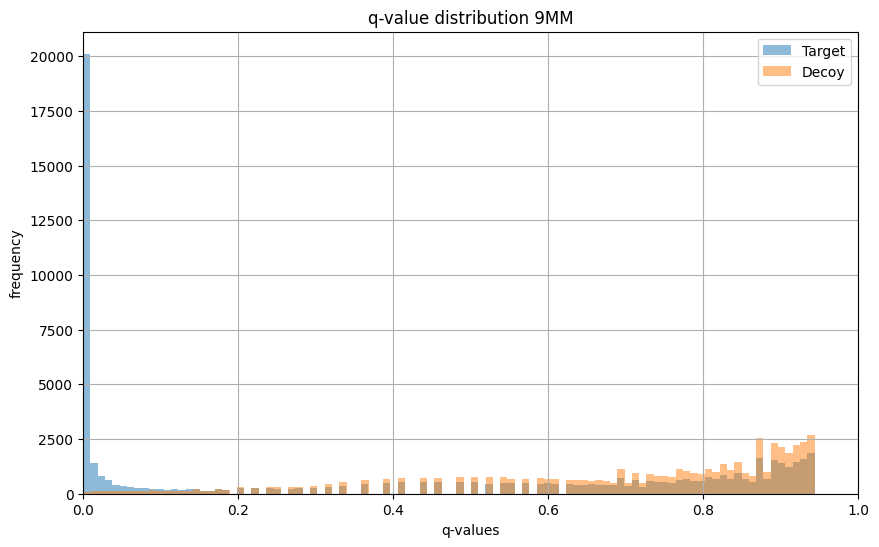

In [7]:
# Inspect q value distribution

# Separate q-values based on is_decoy flag
q_values_target_9MM = [psm.qvalue for psm in psm_list_9MM if not psm.is_decoy]
q_values_decoy_9MM = [psm.qvalue for psm in psm_list_9MM if psm.is_decoy]

# Create histograms for is_decoy=True and is_decoy=False distributions
plt.figure(figsize=(10, 6))

plt.hist(q_values_target_9MM, bins=100, alpha=0.5, label='Target')
plt.hist(q_values_decoy_9MM, bins=100, alpha=0.5, label='Decoy')

plt.xlabel('q-values')
plt.xlim(0, 1)
plt.ylabel('frequency')
plt.title('q-value distribution 9MM')
plt.legend()
plt.grid(True)

plt.show()

In [8]:
psm_df_9MM = psm_list_9MM.to_dataframe()

In [9]:
#Calculate FDR

# Sort dataframe by score in descending order
psm_df_9MM_sorted = psm_df_9MM.sort_values('score', ascending=False)

# Calculate cumulative number of decoy and target hits
psm_df_9MM_sorted['cumulative_decoy'] = psm_df_9MM_sorted['is_decoy'].cumsum()
psm_df_9MM_sorted['cumulative_total'] = psm_df_9MM_sorted['score'].expanding().count()

# Calculate FDR
psm_df_9MM_sorted['FDR'] = psm_df_9MM_sorted['cumulative_decoy'] / psm_df_9MM_sorted['cumulative_total']

# Find score at which FDR first falls below or equals to 1%
fdr_1_percent_score_9MM = psm_df_9MM_sorted[psm_df_9MM_sorted['FDR'] <= 0.01]['score'].min()

In [10]:
print(fdr_1_percent_score_9MM)

3.324236340526027


In [11]:
# Identification rate defined as the ratio of correct hits (PSMs above the fdr_1_percent_score and not decoy) to the total number of target PSMs in the psm_df
correct_hits_9MM = psm_df_9MM[(psm_df_9MM['score'] > fdr_1_percent_score_9MM) & (psm_df_9MM['is_decoy'] == False)]
total_target_psms_9MM = psm_df_9MM[psm_df_9MM['is_decoy'] == False].shape[0]

identification_rate_9MM = len(correct_hits_9MM) / total_target_psms_9MM

# If you want it as a percentage
identification_rate_percent_9MM = identification_rate_9MM * 100

In [12]:
print(identification_rate_percent_9MM)

35.06546048905216


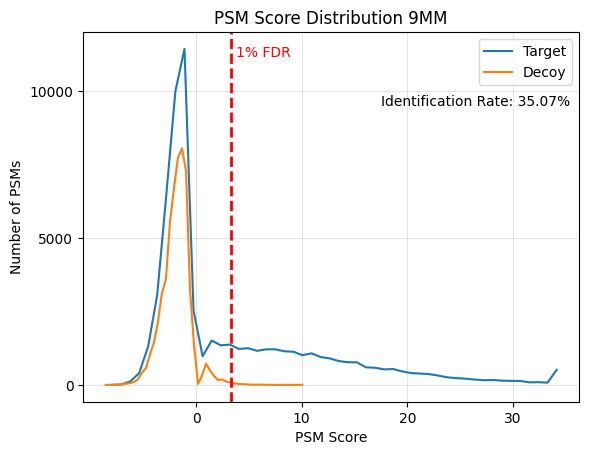

In [13]:
# Visualized by lines instead of bars

# 9MM
# Create separate dataframes for targets and decoys
target_df_9MM = psm_df_9MM[psm_df_9MM['is_decoy'] == False]
decoy_df_9MM = psm_df_9MM[psm_df_9MM['is_decoy'] == True]

# Calculate histograms
target_hist_9MM = np.histogram(target_df_9MM['score'], bins=50)
decoy_hist_9MM = np.histogram(decoy_df_9MM['score'], bins=50)

# Calculate bin centers
target_bin_centers_9MM = 0.5*(target_hist_9MM[1][1:] + target_hist_9MM[1][:-1])
decoy_bin_centers_9MM = 0.5*(decoy_hist_9MM[1][1:] + decoy_hist_9MM[1][:-1])

# Plot lines
plt.plot(target_bin_centers_9MM, target_hist_9MM[0], label='Target')
plt.plot(decoy_bin_centers_9MM, decoy_hist_9MM[0], label='Decoy')

# Add vertical line at 1% FDR score
plt.axvline(fdr_1_percent_score_9MM, color='r', linestyle='dashed', linewidth=2)

# Add labels and title
plt.xlabel('PSM Score')
plt.ylabel('Number of PSMs')
plt.title('PSM Score Distribution 9MM')

# Add grid
plt.grid(True, which='both', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)

# Set y-ticks
plt.yticks(np.arange(0, max(target_hist_9MM[0].max(), decoy_hist_9MM[0].max()), 5000))

# Set x-ticks
plt.xticks(np.arange(0, max(target_df_9MM['score'].max(), decoy_df_9MM['score'].max()), 10))

# Add legend
plt.legend(loc='upper right')

# Add identification rate as text annotation
plt.text(0.60, 0.80, f'Identification Rate: {identification_rate_percent_9MM:.2f}%', transform=plt.gca().transAxes)

# Add text annotation for 1% FDR
plt.text(fdr_1_percent_score_9MM+0.5, plt.gca().get_ylim()[1]*0.93, '1% FDR', color='red', horizontalalignment='left')

# Show plot
plt.show()

### Unmatched metagenome
##### F06 is a complex, natural stool sample which was searched against GUT_DB1IGC, the IGC reference catalogue for the human gut microbiome

In [17]:
F06_target = r"/home/wout/xtandem/output/construction/unmatched_metagenome/input_F06.xml_GUT_DB1IGC.fasta_output.2024_04_24_13_23_25.t.xml"
F06_decoy = r"/home/wout/xtandem/output/construction/unmatched_metagenome/input_F06.xml_GUT_DB1IGC_REVERSED.fasta_output.2024_04_24_14_03_28.t.xml"

reader_F06_target = XTandemReader(F06_target)
reader_F06_decoy = XTandemReader(F06_decoy)

psm_list_F06_target = reader_F06_target.read_file()
psm_list_F06_decoy = reader_F06_decoy.read_file()

In [18]:
for psm in psm_list_F06_target:
    psm.is_decoy = False
for psm in psm_list_F06_decoy:
    psm.is_decoy = True

In [19]:
psm_list_F06 = psm_list_F06_target + psm_list_F06_decoy

In [20]:
# Count the number of instances where is_decoy is True
true_count_F06 = sum(1 for psm in psm_list_F06 if psm.is_decoy == True)

# Count the number of instances where is_decoy is False
false_count_F06 = sum(1 for psm in psm_list_F06 if psm.is_decoy == False)

print(f'Number of decoys: {true_count_F06}, Number of targets: {false_count_F06}')

Number of decoys: 78719, Number of targets: 79039


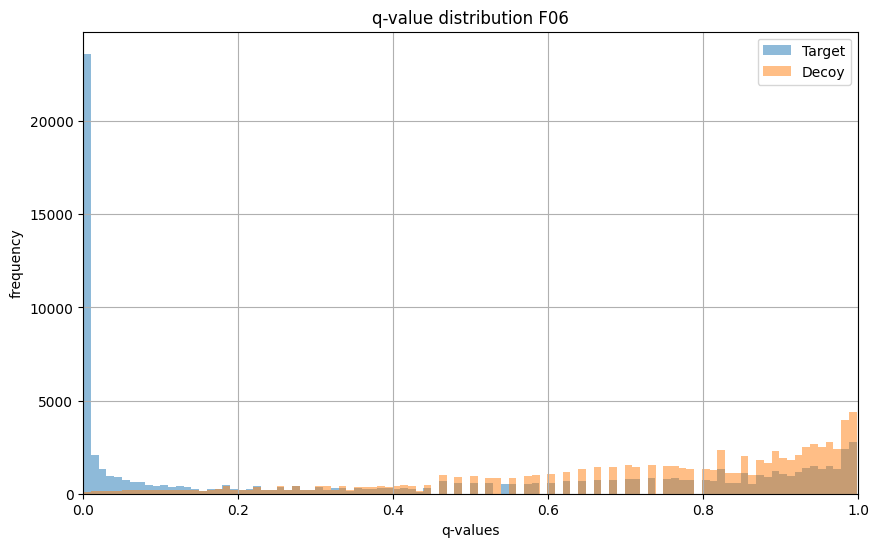

In [21]:
psm_list_F06.calculate_qvalues()

# Inspect q value distribution

# Separate q-values based on is_decoy flag
q_values_target_F06 = [psm.qvalue for psm in psm_list_F06 if not psm.is_decoy]
q_values_decoy_F06 = [psm.qvalue for psm in psm_list_F06 if psm.is_decoy]

# Create histograms for is_decoy=True and is_decoy=False distributions
plt.figure(figsize=(10, 6))

plt.hist(q_values_target_F06, bins=100, alpha=0.5, label='Target')
plt.hist(q_values_decoy_F06, bins=100, alpha=0.5, label='Decoy')

plt.xlabel('q-values')
plt.xlim(0, 1)
plt.ylabel('frequency')
plt.title('q-value distribution F06')
plt.legend()
plt.grid(True)

plt.show()

In [22]:
psm_df_F06 = psm_list_F06.to_dataframe()

In [23]:
# Calculate FDR

# Sort dataframe by score in descending order
psm_df_F06_sorted = psm_df_F06.sort_values('score', ascending=False)

# Calculate cumulative number of decoy and target hits
psm_df_F06_sorted['cumulative_decoy'] = psm_df_F06_sorted['is_decoy'].cumsum()
psm_df_F06_sorted['cumulative_total'] = psm_df_F06_sorted['score'].expanding().count()

# Calculate FDR
psm_df_F06_sorted['FDR'] = psm_df_F06_sorted['cumulative_decoy'] / psm_df_F06_sorted['cumulative_total']

# Find score at which FDR first falls below or equals to 1%
fdr_1_percent_score_F06 = psm_df_F06_sorted[psm_df_F06_sorted['FDR'] <= 0.01]['score'].min()

print(fdr_1_percent_score_F06)

5.318520073865556


In [24]:
# Identification rate defined as the ratio of correct hits (PSMs above the fdr_1_percent_score and not decoy) to the total number of target PSMs in the psm_df
correct_hits_F06 = psm_df_F06[(psm_df_F06['score'] > fdr_1_percent_score_F06) & (psm_df_F06['is_decoy'] == False)]
total_target_psms_F06 = psm_df_F06[psm_df_F06['is_decoy'] == False].shape[0]

identification_rate_F06 = len(correct_hits_F06) / total_target_psms_F06

# If you want it as a percentage
identification_rate_percent_F06 = identification_rate_F06 * 100

print(identification_rate_percent_F06)

32.57758827920394


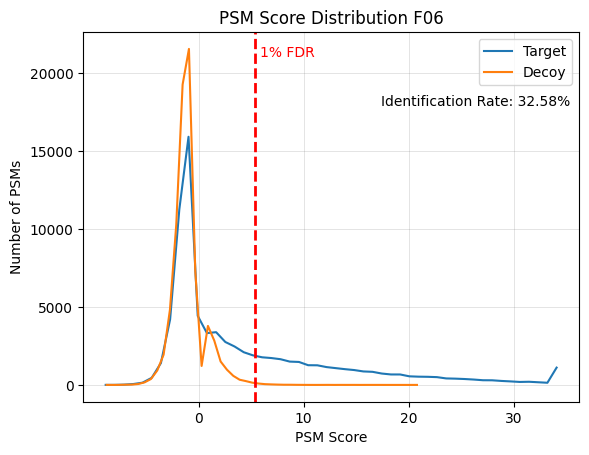

In [25]:
# Visualized by lines instead of bars

# F06

# Create separate dataframes for targets and decoys
target_df_F06 = psm_df_F06[psm_df_F06['is_decoy'] == False]
decoy_df_F06 = psm_df_F06[psm_df_F06['is_decoy'] == True]

# Calculate histograms
target_hist_F06 = np.histogram(target_df_F06['score'], bins=50)
decoy_hist_F06 = np.histogram(decoy_df_F06['score'], bins=50)

# Calculate bin centers
target_bin_centers_F06 = 0.5*(target_hist_F06[1][1:] + target_hist_F06[1][:-1])
decoy_bin_centers_F06 = 0.5*(decoy_hist_F06[1][1:] + decoy_hist_F06[1][:-1])

# Plot lines
plt.plot(target_bin_centers_F06, target_hist_F06[0], label='Target')
plt.plot(decoy_bin_centers_F06, decoy_hist_F06[0], label='Decoy')

# Add vertical line at 1% FDR score
plt.axvline(fdr_1_percent_score_F06, color='r', linestyle='dashed', linewidth=2)

# Add labels and title
plt.xlabel('PSM Score')
plt.ylabel('Number of PSMs')
plt.title('PSM Score Distribution F06')

# Add grid
plt.grid(True, which='both', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)

# Set y-ticks
plt.yticks(np.arange(0, max(target_hist_F06[0].max(), decoy_hist_F06[0].max()), 5000))

# Set x-ticks
plt.xticks(np.arange(0, max(target_df_F06['score'].max(), decoy_df_F06['score'].max()), 10))

# Add legend
plt.legend(loc='upper right')

# Add identification rate as text annotation
plt.text(0.60, 0.80, f'Identification Rate: {identification_rate_percent_F06:.2f}%', transform=plt.gca().transAxes)

# Add text annotation for 1% FDR
plt.text(fdr_1_percent_score_F06+0.5, plt.gca().get_ylim()[1]*0.93, '1% FDR', color='red', horizontalalignment='left')

# Show plot
plt.show()

### Restricted reference database
##### A human stool sample is used in this analysis (human_0) which was searched against 2 different restricted reference protein databases, 1) 16S-G = the taxonomic structure of the human_0 sample is known thanks to 16S rDNA gene sequencing and based on this, all publicly available sequences for the predicted taxa were added in in this database, G stands for genus since this was done on the genus level (the study of origin also provides the same on the S, species and F, family level) 2) PI-G = proteomic iterative database, this DB is formed by first searching the sample against a generic unrestricted reference database (containing the entire set of bacterial sequences deposited in Uniprot) followed by the identification of the main taxa present in the sample, the restricted reference database is then built on the basis of these identified taxa present in the sample
 Tanca, A., et al. (2017)

In [30]:
human0_16S_target = r"/home/wout/xtandem/output/construction/restricted_ref/human_0_16S-G_output.2024_04_23_17_58_29.t.xml"
human0_16S_decoy = r"/home/wout/xtandem/output/construction/restricted_ref/human_0_16S-G_REVERSED.2024_04_23_19_28_22.t.xml"
human0_PI_target = r"/home/wout/xtandem/output/construction/restricted_ref/human_0_PI-G_PD_output.2024_04_23_18_17_40.t.xml"
human0_PI_decoy = r"/home/wout/xtandem/output/construction/restricted_ref/human_0_PI-G_PD_output_decoy.2024_04_23_18_37_18.t.xml"

reader_human0_16S_target = XTandemReader(human0_16S_target)
reader_human0_16S_decoy = XTandemReader(human0_16S_decoy)
reader_human0_PI_target = XTandemReader(human0_PI_target)
reader_human0_PI_decoy = XTandemReader(human0_PI_decoy)

psm_list_human0_16S_target = reader_human0_16S_target.read_file()
psm_list_human0_16S_decoy = reader_human0_16S_decoy.read_file()
psm_list_human0_PI_decoy = reader_human0_PI_decoy.read_file()
psm_list_human0_PI_target = reader_human0_PI_target.read_file()

In [31]:
for psm in psm_list_human0_16S_target:
    psm.is_decoy = False
for psm in psm_list_human0_16S_decoy:
    psm.is_decoy = True
for psm in psm_list_human0_PI_target:
    psm.is_decoy = False
for psm in psm_list_human0_PI_decoy:
    psm.is_decoy = True

In [32]:
psm_list_human0_16S = psm_list_human0_16S_target + psm_list_human0_16S_decoy
psm_list_human0_PI = psm_list_human0_PI_target + psm_list_human0_PI_decoy

In [33]:
true_count_human0_16S = sum(1 for psm in psm_list_human0_16S if psm.is_decoy == True)
false_count_human0_16S = sum(1 for psm in psm_list_human0_16S if psm.is_decoy == False)
print(f'Number of decoys: {true_count_human0_16S}, Number of targets: {false_count_human0_16S}')


true_count_human0_PI = sum(1 for psm in psm_list_human0_PI if psm.is_decoy == True)
false_count_human0_PI = sum(1 for psm in psm_list_human0_PI if psm.is_decoy == False)
print(f'Number of decoys: {true_count_human0_PI}, Number of targets: {false_count_human0_PI}')

Number of decoys: 60012, Number of targets: 60788
Number of decoys: 60106, Number of targets: 60849


In [34]:
psm_list_human0_16S.calculate_qvalues()
psm_list_human0_PI.calculate_qvalues()

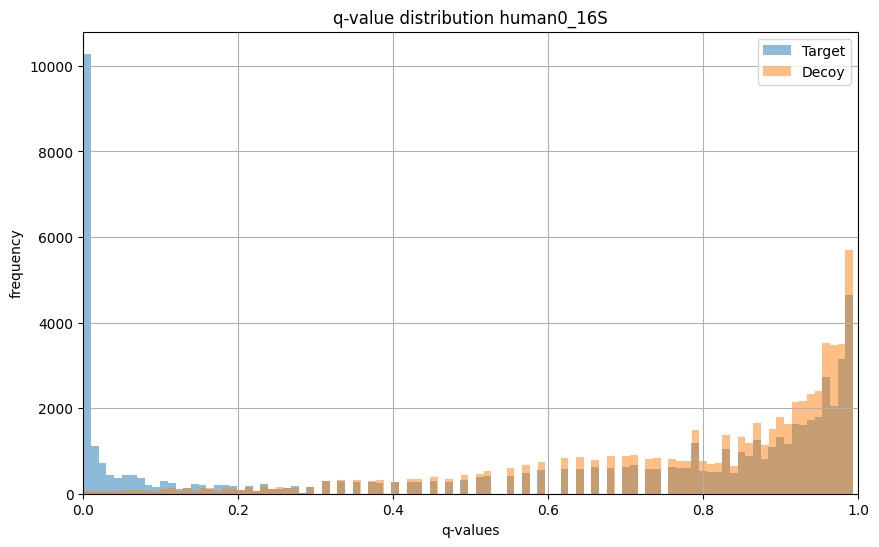

In [35]:
# Inspect q value distribution

# Separate q-values based on is_decoy flag
q_values_target_human0_16S = [psm.qvalue for psm in psm_list_human0_16S if not psm.is_decoy]
q_values_decoy_human0_16S = [psm.qvalue for psm in psm_list_human0_16S if psm.is_decoy]

# Create histograms for is_decoy=True and is_decoy=False distributions
plt.figure(figsize=(10, 6))

plt.hist(q_values_target_human0_16S, bins=100, alpha=0.5, label='Target')
plt.hist(q_values_decoy_human0_16S, bins=100, alpha=0.5, label='Decoy')

plt.xlabel('q-values')
plt.xlim(0, 1)
plt.ylabel('frequency')
plt.title('q-value distribution human0_16S')
plt.legend()
plt.grid(True)

plt.show()

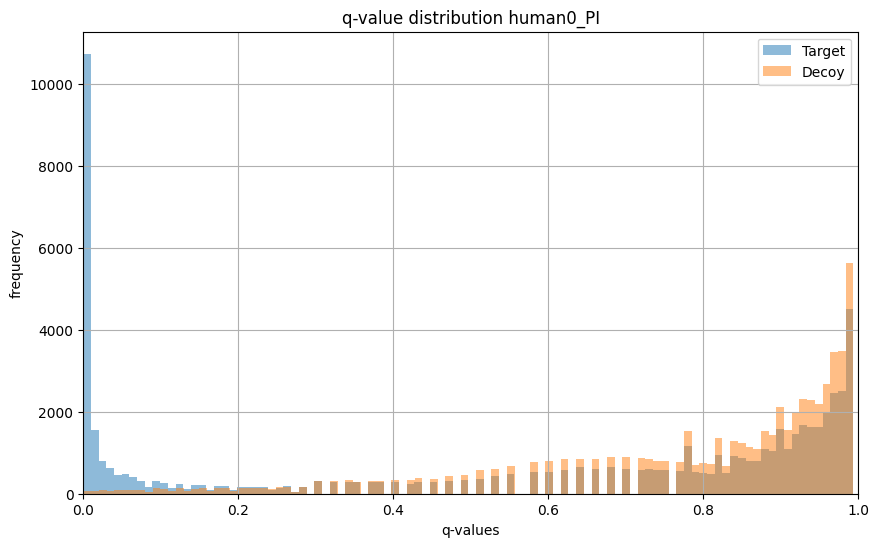

In [36]:
# Inspect q value distribution

# Separate q-values based on is_decoy flag
q_values_target_human0_PI = [psm.qvalue for psm in psm_list_human0_PI if not psm.is_decoy]
q_values_decoy_human0_PI = [psm.qvalue for psm in psm_list_human0_PI if psm.is_decoy]

# Create histograms for is_decoy=True and is_decoy=False distributions
plt.figure(figsize=(10, 6))

plt.hist(q_values_target_human0_PI, bins=100, alpha=0.5, label='Target')
plt.hist(q_values_decoy_human0_PI, bins=100, alpha=0.5, label='Decoy')

plt.xlabel('q-values')
plt.xlim(0, 1)
plt.ylabel('frequency')
plt.title('q-value distribution human0_PI')
plt.legend()
plt.grid(True)

plt.show()

In [37]:
psm_df_human0_16S = psm_list_human0_16S.to_dataframe()
psm_df_human0_PI = psm_list_human0_PI.to_dataframe()

In [38]:
# Calculate FDR

# Sort dataframe by score in descending order
psm_df_human0_16S_sorted = psm_df_human0_16S.sort_values('score', ascending=False)
psm_df_human0_PI_sorted = psm_df_human0_PI.sort_values('score', ascending=False)

# Calculate cumulative number of decoy and target hits
psm_df_human0_16S_sorted['cumulative_decoy'] = psm_df_human0_16S_sorted['is_decoy'].cumsum()
psm_df_human0_16S_sorted['cumulative_total'] = psm_df_human0_16S_sorted['score'].expanding().count()

psm_df_human0_PI_sorted['cumulative_decoy'] = psm_df_human0_PI_sorted['is_decoy'].cumsum()
psm_df_human0_PI_sorted['cumulative_total'] = psm_df_human0_PI_sorted['score'].expanding().count()

# Calculate FDR
psm_df_human0_16S_sorted['FDR'] = psm_df_human0_16S_sorted['cumulative_decoy'] / psm_df_human0_16S_sorted['cumulative_total']
psm_df_human0_PI_sorted['FDR'] = psm_df_human0_PI_sorted['cumulative_decoy'] / psm_df_human0_PI_sorted['cumulative_total']

# Find score at which FDR first falls below or equals to 1%
fdr_1_percent_score_human0_16S = psm_df_human0_16S_sorted[psm_df_human0_16S_sorted['FDR'] <= 0.01]['score'].min()
fdr_1_percent_score_human0_PI = psm_df_human0_PI_sorted[psm_df_human0_PI_sorted['FDR'] <= 0.01]['score'].min()

print(fdr_1_percent_score_human0_16S)
print(fdr_1_percent_score_human0_PI)

4.135166556742355
4.199705077879927


In [39]:
# Identification rate defined as the ratio of correct hits (PSMs above the fdr_1_percent_score and not decoy) to the total number of target PSMs in the psm_df
correct_hits_human0_16S = psm_df_human0_16S[(psm_df_human0_16S['score'] > fdr_1_percent_score_human0_16S) & (psm_df_human0_16S['is_decoy'] == False)]
total_target_psms_human0_16S = psm_df_human0_16S[psm_df_human0_16S['is_decoy'] == False].shape[0]

correct_hits_human0_PI = psm_df_human0_PI[(psm_df_human0_PI['score'] > fdr_1_percent_score_human0_PI) & (psm_df_human0_PI['is_decoy'] == False)]
total_target_psms_human0_PI = psm_df_human0_PI[psm_df_human0_PI['is_decoy'] == False].shape[0]

identification_rate_human0_16S = len(correct_hits_human0_16S) / total_target_psms_human0_16S
identification_rate_human0_PI = len(correct_hits_human0_PI) / total_target_psms_human0_PI

# If you want it as a percentage
identification_rate_percent_human0_16S = identification_rate_human0_16S * 100
identification_rate_percent_human0_PI = identification_rate_human0_PI * 100

In [40]:
print(identification_rate_percent_human0_16S)
print(identification_rate_percent_human0_PI)

18.763571757583733
20.18110404443787


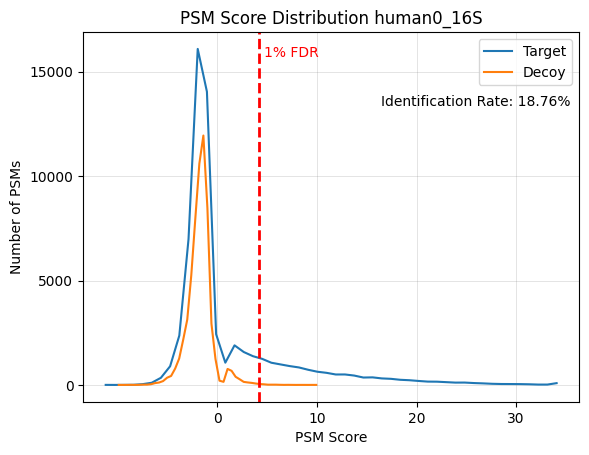

In [41]:
# human0_16S

# Create separate dataframes for targets and decoys
target_df_human0_16S = psm_df_human0_16S[psm_df_human0_16S['is_decoy'] == False]
decoy_df_human0_16S = psm_df_human0_16S[psm_df_human0_16S['is_decoy'] == True]

# Calculate histograms
target_hist_human0_16S = np.histogram(target_df_human0_16S['score'], bins=50)
decoy_hist_human0_16S = np.histogram(decoy_df_human0_16S['score'], bins=50)

# Calculate bin centers
target_bin_centers_human0_16S = 0.5*(target_hist_human0_16S[1][1:] + target_hist_human0_16S[1][:-1])
decoy_bin_centers_human0_16S = 0.5*(decoy_hist_human0_16S[1][1:] + decoy_hist_human0_16S[1][:-1])

# Plot lines
plt.plot(target_bin_centers_human0_16S, target_hist_human0_16S[0], label='Target')
plt.plot(decoy_bin_centers_human0_16S, decoy_hist_human0_16S[0], label='Decoy')

# Add vertical line at 1% FDR score
plt.axvline(fdr_1_percent_score_human0_16S, color='r', linestyle='dashed', linewidth=2)

# Add labels and title
plt.xlabel('PSM Score')
plt.ylabel('Number of PSMs')
plt.title('PSM Score Distribution human0_16S')

# Add grid
plt.grid(True, which='both', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)

# Set y-ticks
plt.yticks(np.arange(0, max(target_hist_human0_16S[0].max(), decoy_hist_human0_16S[0].max()), 5000))

# Set x-ticks
plt.xticks(np.arange(0, max(target_df_human0_16S['score'].max(), decoy_df_human0_16S['score'].max()), 10))

# Add legend
plt.legend(loc='upper right')

# Add identification rate as text annotation
plt.text(0.60, 0.80, f'Identification Rate: {identification_rate_percent_human0_16S:.2f}%', transform=plt.gca().transAxes)

# Add text annotation for 1% FDR
plt.text(fdr_1_percent_score_human0_16S+0.5, plt.gca().get_ylim()[1]*0.93, '1% FDR', color='red', horizontalalignment='left')

# Show plot
plt.show()

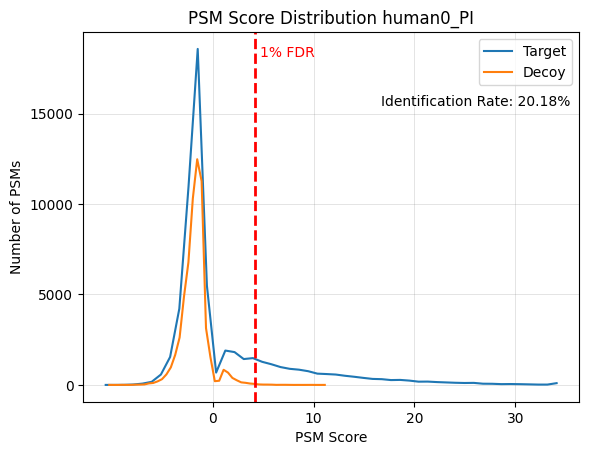

In [42]:
# human0_PI

# Create separate dataframes for targets and decoys
target_df_human0_PI = psm_df_human0_PI[psm_df_human0_PI['is_decoy'] == False]
decoy_df_human0_PI = psm_df_human0_PI[psm_df_human0_PI['is_decoy'] == True]

# Calculate histograms
target_hist_human0_PI = np.histogram(target_df_human0_PI['score'], bins=50)
decoy_hist_human0_PI = np.histogram(decoy_df_human0_PI['score'], bins=50)

# Calculate bin centers
target_bin_centers_human0_PI = 0.5*(target_hist_human0_PI[1][1:] + target_hist_human0_PI[1][:-1])
decoy_bin_centers_human0_PI = 0.5*(decoy_hist_human0_PI[1][1:] + decoy_hist_human0_PI[1][:-1])

# Plot lines
plt.plot(target_bin_centers_human0_PI, target_hist_human0_PI[0], label='Target')
plt.plot(decoy_bin_centers_human0_PI, decoy_hist_human0_PI[0], label='Decoy')

# Add vertical line at 1% FDR score
plt.axvline(fdr_1_percent_score_human0_PI, color='r', linestyle='dashed', linewidth=2)

# Add labels and title
plt.xlabel('PSM Score')
plt.ylabel('Number of PSMs')
plt.title('PSM Score Distribution human0_PI')

# Add grid
plt.grid(True, which='both', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)

# Set y-ticks
plt.yticks(np.arange(0, max(target_hist_human0_PI[0].max(), decoy_hist_human0_PI[0].max()), 5000))

# Set x-ticks
plt.xticks(np.arange(0, max(target_df_human0_PI['score'].max(), decoy_df_human0_PI['score'].max()), 10))

# Add legend
plt.legend(loc='upper right')

# Add identification rate as text annotation
plt.text(0.60, 0.80, f'Identification Rate: {identification_rate_percent_human0_PI:.2f}%', transform=plt.gca().transAxes)

# Add text annotation for 1% FDR
plt.text(fdr_1_percent_score_human0_PI+0.5, plt.gca().get_ylim()[1]*0.93, '1% FDR', color='red', horizontalalignment='left')

# Show plot
plt.show()

### Unrestricted reference database
##### The same human stool sample was used as for the restricted reference database (human0), the database used is UniRef50, a clustered set of sequences from UniProt with selected UniProt Archive records included

In [47]:
human0_uniref50_target = r"/home/wout/xtandem/output/construction/unrestricted_ref/human_0_uniref50.2024_04_24_14_42_59.t.xml"
human0_uniref50_decoy = r"/home/wout/xtandem/output/construction/unrestricted_ref/human_0_uniref50_REVERSED.2024_04_24_23_39_07.t.xml"

reader_human0_uniref50_target = XTandemReader(human0_uniref50_target)
reader_human0_uniref50_decoy = XTandemReader(human0_uniref50_decoy)

psm_list_human0_uniref50_target = reader_human0_uniref50_target.read_file()
psm_list_human0_uniref50_decoy = reader_human0_uniref50_decoy.read_file()

In [49]:
for psm in psm_list_human0_uniref50_target:
    psm.is_decoy = False
for psm in psm_list_human0_uniref50_decoy:
    psm.is_decoy = True

In [50]:
psm_list_human0_uniref50 = psm_list_human0_uniref50_target + psm_list_human0_uniref50_decoy

In [51]:
true_count_human0_uniref50 = sum(1 for psm in psm_list_human0_uniref50 if psm.is_decoy == True)
false_count_human0_uniref50 = sum(1 for psm in psm_list_human0_uniref50 if psm.is_decoy == False)
print(f'Number of decoys: {true_count_human0_uniref50}, Number of targets: {false_count_human0_uniref50}')

Number of decoys: 62235, Number of targets: 62289


In [52]:
psm_list_human0_uniref50.calculate_qvalues()

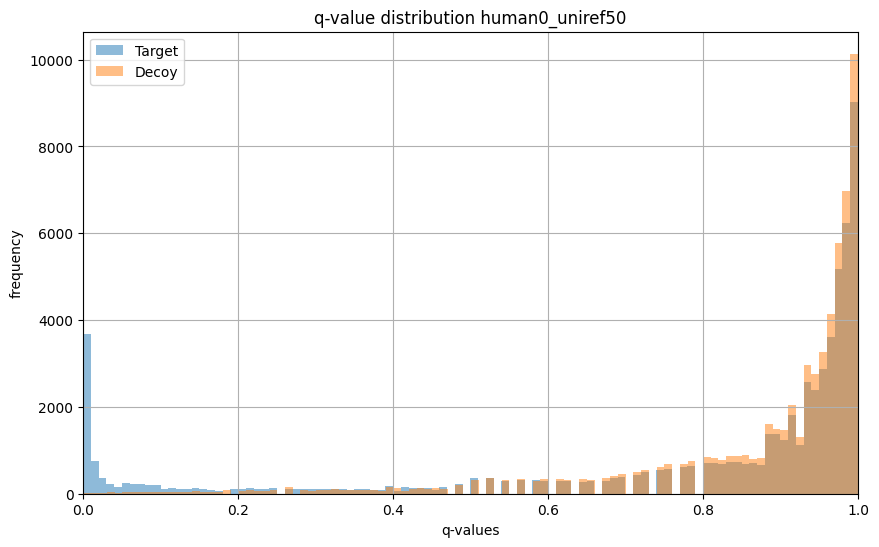

In [53]:
# Inspect q value distribution

# Separate q-values based on is_decoy flag
q_values_target_human0_uniref50 = [psm.qvalue for psm in psm_list_human0_uniref50 if not psm.is_decoy]
q_values_decoy_human0_uniref50 = [psm.qvalue for psm in psm_list_human0_uniref50 if psm.is_decoy]

# Create histograms for is_decoy=True and is_decoy=False distributions
plt.figure(figsize=(10, 6))

plt.hist(q_values_target_human0_uniref50, bins=100, alpha=0.5, label='Target')
plt.hist(q_values_decoy_human0_uniref50, bins=100, alpha=0.5, label='Decoy')

plt.xlabel('q-values')
plt.xlim(0, 1)
plt.ylabel('frequency')
plt.title('q-value distribution human0_uniref50')
plt.legend()
plt.grid(True)

plt.show()

In [54]:
psm_df_human0_uniref50 = psm_list_human0_uniref50.to_dataframe()

In [55]:
# Calculate FDR

# Sort dataframe by score in descending order
psm_df_human0_uniref50_sorted = psm_df_human0_uniref50.sort_values('score', ascending=False)

# Calculate cumulative number of decoy and target hits
psm_df_human0_uniref50_sorted['cumulative_decoy'] = psm_df_human0_uniref50_sorted['is_decoy'].cumsum()
psm_df_human0_uniref50_sorted['cumulative_total'] = psm_df_human0_uniref50_sorted['score'].expanding().count()

# Calculate FDR
psm_df_human0_uniref50_sorted['FDR'] = psm_df_human0_uniref50_sorted['cumulative_decoy'] / psm_df_human0_uniref50_sorted['cumulative_total']

# Find score at which FDR first falls below or equals to 1%
fdr_1_percent_score_human0_uniref50 = psm_df_human0_uniref50_sorted[psm_df_human0_uniref50_sorted['FDR'] <= 0.01]['score'].min()

print(fdr_1_percent_score_human0_uniref50)

5.381698975487088


In [56]:
# Identification rate defined as the ratio of correct hits (PSMs above the fdr_1_percent_score and not decoy) to the total number of target PSMs in the psm_df
correct_hits_human0_uniref50 = psm_df_human0_uniref50[(psm_df_human0_uniref50['score'] > fdr_1_percent_score_human0_uniref50) & (psm_df_human0_uniref50['is_decoy'] == False)]
total_target_psms_human0_uniref50 = psm_df_human0_uniref50[psm_df_human0_uniref50['is_decoy'] == False].shape[0]

identification_rate_human0_uniref50 = len(correct_hits_human0_uniref50) / total_target_psms_human0_uniref50

# If you want it as a percentage
identification_rate_percent_human0_uniref50 = identification_rate_human0_uniref50 * 100

In [57]:
print(identification_rate_percent_human0_uniref50)

7.092745107482862


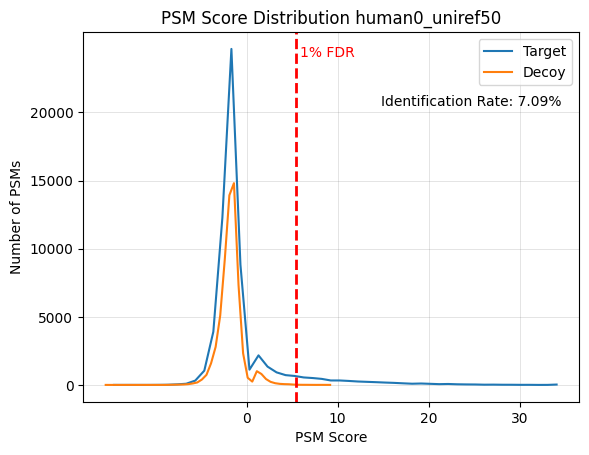

In [58]:
# human0_uniref50

# Create separate dataframes for targets and decoys
target_df_human0_uniref50 = psm_df_human0_uniref50[psm_df_human0_uniref50['is_decoy'] == False]
decoy_df_human0_uniref50 = psm_df_human0_uniref50[psm_df_human0_uniref50['is_decoy'] == True]

# Calculate histograms
target_hist_human0_uniref50 = np.histogram(target_df_human0_uniref50['score'], bins=50)
decoy_hist_human0_uniref50 = np.histogram(decoy_df_human0_uniref50['score'], bins=50)

# Calculate bin centers
target_bin_centers_human0_uniref50 = 0.5*(target_hist_human0_uniref50[1][1:] + target_hist_human0_uniref50[1][:-1])
decoy_bin_centers_human0_uniref50 = 0.5*(decoy_hist_human0_uniref50[1][1:] + decoy_hist_human0_uniref50[1][:-1])

# Plot lines
plt.plot(target_bin_centers_human0_uniref50, target_hist_human0_uniref50[0], label='Target')
plt.plot(decoy_bin_centers_human0_uniref50, decoy_hist_human0_uniref50[0], label='Decoy')

# Add vertical line at 1% FDR score
plt.axvline(fdr_1_percent_score_human0_uniref50, color='r', linestyle='dashed', linewidth=2)

# Add labels and title
plt.xlabel('PSM Score')
plt.ylabel('Number of PSMs')
plt.title('PSM Score Distribution human0_uniref50')

# Add grid
plt.grid(True, which='both', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)

# Set y-ticks
plt.yticks(np.arange(0, max(target_hist_human0_uniref50[0].max(), decoy_hist_human0_uniref50[0].max()), 5000))

# Set x-ticks
plt.xticks(np.arange(0, max(target_df_human0_uniref50['score'].max(), decoy_df_human0_uniref50['score'].max()), 10))

# Add legend
plt.legend(loc='upper right')

# Add identification rate as text annotation
plt.text(0.60, 0.80, f'Identification Rate: {identification_rate_percent_human0_uniref50:.2f}%', transform=plt.gca().transAxes)

# Add text annotation for 1% FDR
plt.text(fdr_1_percent_score_human0_uniref50+0.5, plt.gca().get_ylim()[1]*0.93, '1% FDR', color='red', horizontalalignment='left')

# Show plot
plt.show()